### ZAIN SHAFIQUE
### 290213
### BESE-10A 

# Lets starts with the basics

1. Loading data and data preparation
3. Defining the model
4. Setting up and Fit the model
5. Presentation of results

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [60]:
# Importing the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

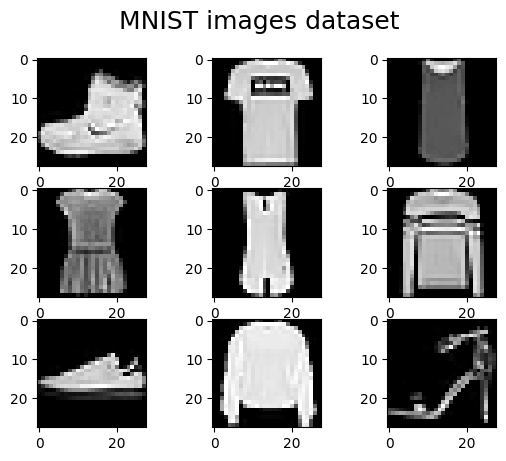

In [61]:

# Looking at the figures
plt.suptitle("MNIST images dataset", fontsize = 18)
c = 1
for i in range(9):
 plt.subplot(3, 3, c)
 plt.imshow(X_train[i], cmap='gray')
 c = c + 1
plt.show()

In [51]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [52]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

# Working with VGG16

## What changes do we have to worry about?

1. Change the grid input dimension: The VGG16 was initially trained for color images. Therefore, it needs to receive images with color channels. That is, each pixel of the image will be represented by more than one value. Typically, we use the RGB color system, that is, each pixel of the image is composed of three values. We can therefore say that an image 32 pixels wide and 32 pixels high in the RGB system has a dimensionality of 32x32x3. As the Fashion MNIST images are in grayscale (that is, they only have one color channel and, therefore, each image has a size of 28x28x1), it is necessary to resize the dataset images to 32x32x3, adding another two channels to use the VGG16;


2. Change the output layer: The output layer of the original VGG16 has 1000 neurons, which correspond to the number of classes in the ImageNet dataset. For Fashion MNIST, you need to change the number of neurons in the output layer to 10, which is the number of classes in the dataset. Therefore, it is necessary to replace the VGG16 output layer with a new dense layer with 10 neurons and a softmax activation layer for classification;

3. Tuning the optimizer learning rate: As Fashion MNIST is a simpler dataset compared to ImageNet, it may be necessary to adjust the optimizer learning rate to a lower value in order to avoid overfitting.

In [53]:
## In the sections below, we'll create basic functions to better organize our code.

def carregamento_dados():
  
# Define the number of classes in the dataset
   num_classes = 10

# Load the Fashion MNIST dataset
   (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Resize the images to the VGG16 input size (32x32x3)
   X_train = np.array([cv2.resize(img, (32, 32)) for img in X_train])
   X_test = np.array([cv2.resize(img, (32, 32)) for img in X_test])

# Add a channel for grayscale (3rd dimension) images
   X_train = np.stack((X_train,) * 3, axis=-1)
   X_test = np.stack((X_test,) * 3, axis=-1)

# Normalize the images
   X_train = X_train.astype('float32') / 255
   X_test = X_test.astype('float32') / 255

# Convert labels to one-hot encoding format
   y_train = to_categorical(y_train)
   y_test = to_categorical(y_test)


   return X_train, y_train, X_test, y_test

In [54]:
def modelo_compile():
    
# Load the VGG16 model without the output layer
   base_model = VGG16(weights = None, include_top=False, input_shape=(32, 32, 3))

# Add custom dense layers on top of model
   modelo = Sequential()
   modelo.add(base_model)
   modelo.add(Flatten())
   modelo.add(Dense(256, activation='relu'))
   modelo.add(Dropout(0.5))
   modelo.add(Dense(10, activation='softmax'))

# Set the Adam optimizer with reduced learning rate
   optimizer = Adam(learning_rate=0.0002) # Original is 0.0001

# Compile the model
   modelo.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

   return modelo

In [55]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


In [56]:
def modelo_fit(modelo, X_train, y_train, X_test, y_test):

# Setting callbacks
  earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min') # Monitora as épocas e para caso não esteja melhorando
  mcp_save = ModelCheckpoint('best_weights.hdf5', save_best_only = True, monitor = 'val_loss', mode = 'min') # Salvando a melhor configuração
  reduce_lr_loss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 7, verbose = 1, min_delta = 1e-4, mode = 'auto') # Reduz o learning_rate quando a métrica de avaliação para de melhorar

# Training model
  history = modelo.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data = (X_test, y_test), callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

  # Evaluate model
  _, acc = modelo.evaluate(X_test, y_test, verbose=0)
  print('> %.3f' % (acc * 100.0))

# Saving metrics
  scores = acc
  historico = history

  # Plot training history
  plot_training_history(history)

  return scores, historico

In [57]:
## Runing all

def rodando_tudo():
  

    X_train, y_train, X_test, y_test = carregamento_dados()
 # Compilação do modelo base
    modelo = modelo_compile()
 # fit com configurações pre-estabelecidas
    scores, historico = modelo_fit(modelo, X_train, y_train, X_test, y_test)


Epoch 1/20
1875/1875 [==============================] - 56s 29ms/step - loss: 0.6579 - accuracy: 0.7558 - val_loss: 0.4437 - val_accuracy: 0.8371 - lr: 2.0000e-04
Epoch 2/20
1875/1875 [==============================] - 54s 29ms/step - loss: 0.3552 - accuracy: 0.8744 - val_loss: 0.3152 - val_accuracy: 0.8881 - lr: 2.0000e-04
Epoch 3/20
1875/1875 [==============================] - 54s 29ms/step - loss: 0.2772 - accuracy: 0.9035 - val_loss: 0.2609 - val_accuracy: 0.9051 - lr: 2.0000e-04
Epoch 4/20
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2415 - accuracy: 0.9166 - val_loss: 0.2460 - val_accuracy: 0.9135 - lr: 2.0000e-04
Epoch 5/20
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2069 - accuracy: 0.9289 - val_loss: 0.2224 - val_accuracy: 0.9222 - lr: 2.0000e-04
Epoch 6/20
1875/1875 [==============================] - 53s 28ms/step - loss: 0.1820 - accuracy: 0.9360 - val_loss: 0.2290 - val_accuracy: 0.9214 - lr: 2.0000e-04
Epoch 7/20
1875/1875 [

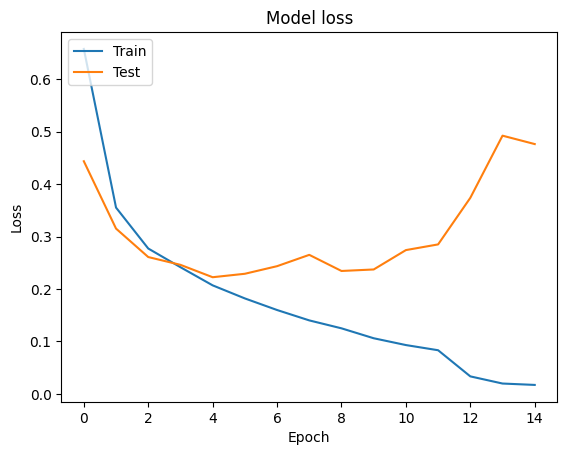

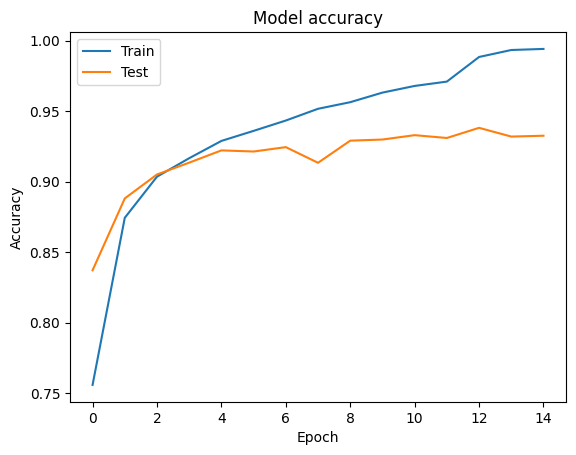

NameError: ignored

In [58]:
rodando_tudo()